# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from sklearn.utils import shuffle

## Load the Data


In [70]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/NLP/NMT/R10_External_Lab/")

In [72]:
npz = np.load('input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


This is: Ship


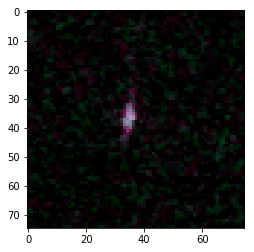

In [73]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
labels = ['Ship','Iceberg']
print ('This is:',labels[int(Y_train[0])])

# Creating the structure of Siamese Network

In [74]:
# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# We will use 2 instances of 1 network for this task
convnet = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.001, decay=2.5e-4)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
# We will use 2 instances of 1 network for this task
convnet = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

# Process the left and right inputs to the same Base Network(base_network)

In [0]:
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = convnet(left_input)

In [0]:
encoded_r = convnet(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

In [0]:
# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
optimizer = Adam(0.001, decay=2.5e-4)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

# Show the Summary of your Siamese Network

In [81]:
siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 18)           0           sequential_1[1][0]         

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

In [77]:
left_input.shape

(5000, 75, 75, 3)

In [78]:
right_input.shape

(5000, 75, 75, 3)

In [79]:
test_left.shape

(3113, 75, 75, 3)

In [80]:
test_right.shape

(3113, 75, 75, 3)

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [82]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))


Train on 5000 samples, validate on 3113 samples
Epoch 1/30
5000/5000 [==============================] - 11s 2ms/step - loss: 0.6761 - acc: 0.5746 - val_loss: 0.6749 - val_acc: 0.5798
Epoch 2/30
5000/5000 [==============================] - 4s 744us/step - loss: 0.6024 - acc: 0.6814 - val_loss: 0.6780 - val_acc: 0.5853
Epoch 3/30
5000/5000 [==============================] - 4s 755us/step - loss: 0.5213 - acc: 0.7564 - val_loss: 0.6450 - val_acc: 0.5943
Epoch 4/30
5000/5000 [==============================] - 4s 758us/step - loss: 0.4673 - acc: 0.7896 - val_loss: 0.7125 - val_acc: 0.5365
Epoch 5/30
5000/5000 [==============================] - 4s 767us/step - loss: 0.4284 - acc: 0.8086 - val_loss: 0.5048 - val_acc: 0.7594
Epoch 6/30
5000/5000 [==============================] - 4s 760us/step - loss: 0.3998 - acc: 0.8252 - val_loss: 0.5497 - val_acc: 0.7298
Epoch 7/30
5000/5000 [==============================] - 4s 741us/step - loss: 0.3749 - acc: 0.8366 - val_loss: 0.6152 - val_acc: 0.6714
